In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Gaussian():
    ''' 一般次元のガウス分布 '''
    def __init__(self, mus, sigmas):
        self.mus = np.array(mus); self.sigmas = np.array(sigmas)
        self.cov = np.diagflat(sigmas)
        self.type= ''
    def sample(self, N):
        return np.random.multivariate_normal(self.mus, self.cov, N)
    
def return_q(X):
    ''' サンプルXから最尤推定したガウス分布を返す '''
    mu_ML = np.average(X, axis=0)
    return Gaussian(mu_ML, np.ones(len(mu_ML)))
    
def plot_w_errors(x, averages, stds, ax, color, label):
    ''' エラーバー付きプロット '''
    ax.plot(x, averages, "o-", color=color, label=label)
    ax.fill_between(x, averages-stds, averages+stds, color=color, alpha=0.3)
    
def plot_metric_and_asymptotics(D=2, Metric=None, fig=None, lower_bound=-0.2, upper_bound=3,
                               estimator=return_q):
    ''' N毎のプロットのサブルーチン '''
    if fig is None:
        fig=plt.figure(figsize=(14,4)); fig.add_subplot(121); fig.add_subplot(122)
    p = Gaussian(np.zeros(D), np.ones(D))
    #ax.set_title(Metric.name, fontsize=20, color=Metric.color)
    Ns = np.arange(1,30); fig.axes[0].set_xlabel("N")
    averages = []; stds = []
    for N in Ns:
        values = []
        for trial in range(100):
            X = p.sample(N); q = estimator(X)
            values.append(Metric(p, q, X))
        averages.append(np.average(values)); stds.append(np.std(values))
    averages, stds = np.array(averages), np.array(stds)
    plot_w_errors(Ns, averages, stds, fig.axes[0], color=Metric.color, label=Metric.name + ' (D=%d)'%D)
    fig.axes[0].set_ylim(lower_bound, upper_bound)
    fig.axes[0].legend(fontsize=20)
    
    fig.axes[1].set_xlabel("N"); fig.axes[1].set_ylim(lower_bound, upper_bound)
    signD = (-1)**(1 - (Metric.color=='red'))*D**(q.type=='')
    fig.axes[1].plot(Ns, signD/(2*Ns), "-", color=Metric.color, label=r'$\frac{%d}{2N}$'%signD)
    fig.axes[1].legend(fontsize=20)
    return None

class KL():
    def __init__(self):
        self.name = r"$D_{KL}$"
        self.color = 'red'
    def __call__(self, p, q, X=None):
        r = p.sigmas**2/q.sigmas**2
        return np.sum((-np.log(r) + (r-1) + (p.mus-q.mus)**2/q.sigmas**2))/2
    
class NLL():
    def __init__(self):
        self.name = "NLL-S"#r"$\frac{-\log P_N(\theta_{ML}^{(N)})}{N}-S(p)$"
        self.color = 'blue'
    def __call__(self, p, q, X=None):
        summand = np.sum((X-q.mus.reshape(1,-1))**2-1, axis=1)
        return np.average(summand)/2
    
def plot_all(D, bound, estimator=return_q):
    fig = plt.figure(figsize=(14,4)); fig.add_subplot(121); fig.add_subplot(122)
    plot_metric_and_asymptotics(D, KL(), fig=fig, lower_bound=-bound, upper_bound=bound, estimator=estimator)
    plot_metric_and_asymptotics(D, NLL(), fig=fig, lower_bound=-bound, upper_bound=bound, estimator=estimator)
    fig.axes[0].axhline(y=0, xmin=0, xmax=30, color='black', ls="-.")
    fig.axes[1].axhline(y=0, xmin=0, xmax=30, color='black', ls="-.")

## 2-3. ガウス分布における最尤推定
前節の内容をまとめると、本当は ${\color{red}{D_{KL}(p\|q_\theta)}}$ を小さくしたいが、実際には ${\color{blue}{\frac{- \log P_N(\theta)}{N}}}$ を小さくすること(=最尤推定)くらいしかできないということ：

本当に最小化したいもの(<span style="color: red; ">汎化誤差</span>とよばれる)|仕方無く最小化するもの(<span style="color: blue; ">経験誤差</span>とよばれる)
:---:|:---:
$\color{red}{D_{KL}(p\mid\mid q_\theta)}$|$\color{blue}{- \frac{\log P_N(\theta)}{N}}$

なのでした。

> $- \langle \log q_\theta({\bf x}) \rangle_{p}$ を汎化誤差と呼ぶほうが一般的かもしれません。いずれにせよ両者の差はデータ生成確率 $p({\bf x})$ のエントロピー分だけなので、モデルを作る立場ではどちらを汎化誤差と呼んでも問題ないでしょう。

<span style="color: blue; ">経験誤差</span>を小さくするパラメータ$\theta_{ML}$を見つける(最尤推定する)ことで、<span style="color: red; ">汎化誤差</span>も小さくなるだろう、というのが大雑把なシナリオというわけです。しかし、果たしてそんなにうまくいくでしょうか？
それを体感するために以下の例題を考えてみます。

### ガウス分布の最尤推定
データ生成分布を1次元標準正規分布

$$
p(x) = \frac{1}{\sqrt{2 \pi }} e^{- \frac{x^2}{2}}
$$

とし、この分布からのサンプルデータ $x_1, x_2, \dots, x_N$ が与えられた時に最尤推定するとどうなるか考えてみましょう。モデルはシンプルに

$$
q_{\theta} (x)=\frac{1}{\sqrt{2 \pi }} e^{- \frac{(x- \theta)^2}{2}}
$$

だとしてみます。経験誤差(負の対数尤度$/N$)は

$$
\frac{- \log P_N(\theta)}{N}=\frac{1}{N} \sum_{n=1}^N\Big(\frac{(x_n - \theta)^2}{2}+ \log \sqrt{2 \pi}\Big)
$$

となるので、これを最小化するモデルパラメータ $\theta_{ML}$ は

$$
0 = \frac{\partial}{\partial \theta}(- \log P_N(\theta)) = \frac{1}{N} \sum_{n=1}^N {(x_n - \theta)}\quad\Rightarrow\quad\theta_{ML}^{(N)}=\frac{1}{N} \sum_{n =1}^N x_n
$$

だとわかります。実際に標準正規分布を最尤推定してみましょう：

In [2]:
def return_q(X):
    ''' サンプルXから最尤推定したガウス分布を返す '''
    mu_ML = np.average(X, axis=0)
    return Gaussian(mu_ML, np.ones(len(mu_ML)))

この実装で実際に動かすと：

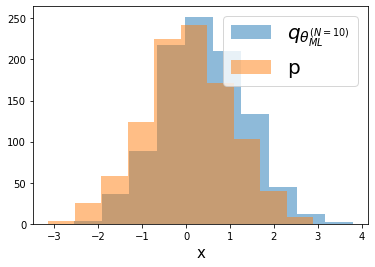

In [3]:
p = Gaussian([0], [1])
N=10; X = p.sample(N); q = return_q(X)
plt.xlabel("x", fontsize=15)
plt.hist(q.sample(1000), alpha=.5, label=r"$q_{\theta_{ML}^{(N=%d)}}$"%N)
plt.hist(p.sample(1000), alpha=.5, label="p")
plt.legend(fontsize=20); plt.show()

となって、たしかに $N$ を増やしていくと、だんだん $q_{\theta_{ML}^{(N)}}$ は $p$ に近づいていきます。 これは
- 経験確率に基づく <span style="color: blue; ">経験誤差</span> を最小化するように $q_{\theta_{ML}^{(N)}}$ は作られた
- 経験確率 $\hat{p}_N$ が $N \to \infty$ で真の確率 $p$ に収束する

ことを踏まえると自然に期待できる振る舞いです。しかし、**ここが重要な問題意識なのですが**、実際に機械学習する際にサンプル数(データ数) $N \to \infty$ は取れません。目的は、
- 有限の $N$ による<span style="color: blue; ">経験誤差</span>最小化を行うことで、<span style="color: red; ">汎化誤差</span>も最小化する

ことです。**こんな魔法のようなこと(汎化, generalizationといいます)は不可能に思われます**が、ある程度の洞察を得ることは可能です。それを以下で説明してみます。

#### ● <span style="color: red; ">汎化誤差</span> の $N \approx \infty$ での振る舞い
まず ${\color{red}{D_{KL}(p\|q_{\theta_{ML}^{(N)}})}}$ の値はどうなるでしょうか？ はじめに数値実験してみます。

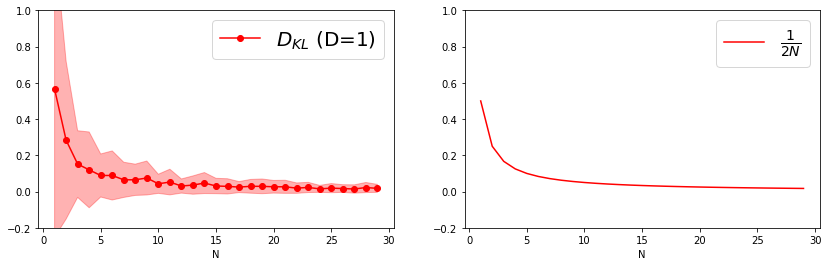

In [4]:
plot_metric_and_asymptotics(1, KL(), lower_bound=-0.2, upper_bound=1); plt.show()

こんな感じで、$N$ を増やすとだんだん減ってゆきます。一緒に $\frac{1}{2N}$ もプロットしてみましたが、`average` とピタリと合っているのがわかります。すなわち<span style="color: red; ">汎化誤差</span> ${\color{red}{:D_{KL}(p\|q_{\theta_{ML}^{(N)}})}}$ は $\frac{1}{N}$ 展開の主要項として

$$
Conjecture: \color{red}{D_{KL}(p\|q_{\theta_{ML}^{(N)}})} \approx \frac{1}{2N}
$$

を持つだろう、と予想できます。まずはこれを**導出**してみましょう。まずガウス分布間の $D_{KL}$ 使うと、

$$
\color{red}{D_{KL}(p\|q_{\theta_{ML}^{(N)}})}=\frac{1}{2} \Big(- \log \frac{1}{1}+( \frac{1}{1} -1 )+\frac{1}{1} (0 - \theta_{ML}^{(N)})^2\Big)=\frac{1}{2} (\theta_{ML}^{(N)})^2
$$

がわかりますから、$(\theta_{ML}^{(N)})^2$ がサンプル数 $N$ に対してどのように振る舞うか考えれば良さそうです。$\theta_{ML}^{(N)}$ はサンプル $x_n$ に依存する確率変数です。したがって$(\theta_{ML}^{(N)})^2$も確率変数ですから、**大数の法則** のため、サンプル数を多くすれば期待値に収束してゆくはずです。そこで期待値を計算してみましょう：

$$
\left. \begin{array}{ll}
\langle
(\theta_{ML}^{(N)})^2
\rangle_p &=
\Big\langle
\Big(
\frac{1}{N}
\sum_{n=1}^N (x_n )
\Big)^2
\Big\rangle_{x_1, x_2, \dots, x_n \sim p(x)}
 \\
&= 
\frac{1}{N^2}
\Big\langle
\sum_{n=1}^N
\sum_{m=1}^N
 (x_n )
 (x_m )
\Big\rangle_{x_1, x_2, \dots, x_n \sim p(x)}
 \\
&= 
\frac{1}{N^2}
\Big\langle
\Big(
\sum_{n = m}
+
\sum_{n \neq m}
\Big)
 (x_n )
 (x_m )
\Big\rangle_{x_1, x_2, \dots, x_n \sim p(x)}
 \\
&= 
\frac{1}{N^2}
\Big\langle
\sum_{n = 1}^N
 (x_n )^2
+
\sum_{n \neq m}
 (x_n )
 (x_m )
\Big\rangle_{x_1, x_2, \dots, x_n \sim p(x)}
 \\
&= 
\frac{1}{N^2}
\Big(
\sum_{n = 1}^N
\underbrace{\langle (x_n )^2 \rangle_{x_n \sim p(x)}}_{1}
+
\sum_{n \neq m}
\underbrace{ \langle (x_n ) \rangle_{x_n \sim p(x)} }_0
\underbrace{ \langle (x_m ) \rangle_{x_m \sim p(x)}}_0
 \Big)
 \\
&= 
\frac{1}{N}
\end{array} \right.
$$

これで

$$
\color{red}{D_{KL}(p\|q_{\theta_{ML}^{(N)}})}=\frac{1}{2}(\theta_{ML}^{(N)})^2 \to \frac{1}{2N}
$$

が示せました。

#### ● <span style="color: blue; ">経験誤差</span> の $N \to \infty$ での振る舞い
次に $\color{blue}{-\frac{\log P_N(\theta_{ML}^{(N)})}{N}}$ の値を考えます。まず、この負の対数尤度(**Negative Log-Likelihood, NLL**)は

$$
\color{blue}{NLL := -\frac{\log P_N(\theta_{ML}^{(N)})}{N}}=\frac{1}{2N} \sum_{n=1}^N \left( (x_n - \theta_{ML}^{(N)})^2 + \log 2 \pi\right)
$$

だったわけですが、$\log 2\pi$が邪魔な気がします。これはターゲット分布 $p(x)$ のエントロピーで打ち消すことができます：

$$
S(p) = - \langle \log p(x) \rangle_p =\frac{1}{2}\Big\langle \underbrace{x^2}_{\to 1} + \log 2\pi \Big\rangle_p
$$

$$
\color{blue}{NLL} - S(p) = \frac{1}{2N} \sum_{n=1}^N \left((x_n - \theta_{ML}^{(N)})^2 - 1 \right)
$$

この関数の $N$ 依存性を見てみます。
同様に実験から：

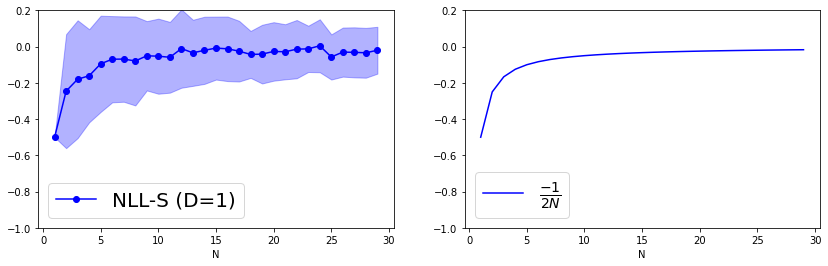

In [5]:
plot_metric_and_asymptotics(1, NLL(), lower_bound=-1, upper_bound=0.2); plt.show()

再び、$\frac{-1}{2N}$ と平均値が一致しているように見えます。実際 $N\to \infty$ でこの振る舞いに漸近することが示せます。上でやったのと同様に計算できる$\langle (x_n ) (\theta_{ML}^{(N)})\rangle_{p} = \frac{1}{N}$を使うと、

$$
\left. \begin{array}{ll}
(x_n - \theta_{ML}^{(N)})^2
&=
\underbrace{ (x_n )^2 }_{\to 1}- 2 \underbrace{ (x_n ) (\theta_{ML}^{(N)} )}_{\to \frac{1}{N}}+\underbrace{ (\theta_{ML}^{(N)} )^2 }_{\to \frac{1}{N}}
 \\
&\to 
1 - \frac{2}{N}+ \frac{1}{N} =1 - \frac{1}{N}
\end{array} \right.
$$

がわかるので、

$$
\left. \begin{array}{ll}
\color{blue}{NLL} - S(p) &= \frac{1}{2N} \sum_{n=1}^N \Big(\underbrace{(x_n - \theta_{ML}^{(N)})^2}_{\to 1 - \frac{1}{N}} - 1 \Big)
\\
&\to \frac{-1}{2N} 
\end{array} \right.
$$

がわかります。

#### ● <span style="color: red; ">汎化誤差</span>と<span style="color: blue; ">経験誤差</span>の関係
まとめてプロットすると

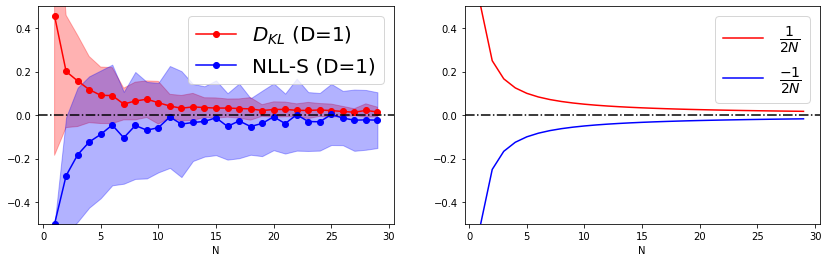

In [6]:
plot_all(D=1, bound=.5); plt.show()

本当に最小化したいもの(<span style="color: red; ">汎化誤差</span>とよばれる)|仕方無く最小化するもの(<span style="color: blue; ">経験誤差</span>とよばれる)
:---:|:---:
$\color{red}{D_{KL}(p\mid\mid q_{\theta_{ML}^{(N)}})} \approx \frac{1}{2N}$|$\color{blue}{- \frac{\log P_N({\theta_{ML}^{(N)}})}{N}}-S(p) \approx - \frac{1}{2N}$

となることが、数値的にも理論的にも確かめられました。何か法則のようなものがあるような気配がするので、$D$次元の${\bf x}$、$D$個の平均パラメータ$\Theta$のケース

$$
{\bf x} = (x^1, x^2, \dots, x^D),\quad p({\bf x}) = \frac{e^{- \frac{{\bf x}^2}{2}}}{\sqrt{(2\pi)^D}}, \quad \Theta=(\theta_1, \theta_2, \dots, \theta_D), \quad q_{\Theta}({\bf x}) = \frac{e^{- \frac{({\bf x - \Theta})^2}{2}}}{\sqrt{(2\pi)^D}}
$$

で同じ計算をしてみます：


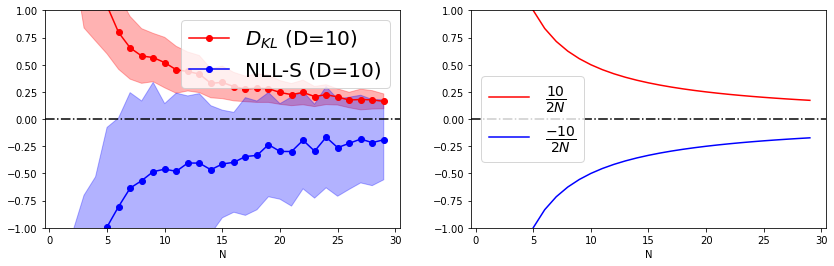

In [7]:
plot_all(D=10, bound=1); plt.show()

このように、学習(最尤推定)パラメータ $\Theta$ が$D$個あるとき、

本当に最小化したいもの(<span style="color: red; ">汎化誤差</span>とよばれる)|仕方無く最小化するもの(<span style="color: blue; ">経験誤差</span>とよばれる)
:---:|:---:
$\color{red}{D_{KL}(p\mid\mid q_{\Theta_{ML}^{(N)}})} \approx \frac{D}{2N}$|$\color{blue}{- \frac{\log P_N(\Theta_{ML}^{(N)})}{N}}-S(p) \approx - \frac{D}{2N}$

であることがわかります。誠実に疑い深い人は、「$D$ は ${\bf x}$ の次元でもあるから、$\frac{D}{2N}$ の $D$ が $\Theta = (\theta_1, \theta_2, \dots, \theta_D)$ の個数と対応すると考えるのは早計だ」と言うでしょう。そんな人のために ${\bf x}$ は$D$次元だが、学習パラメータは1個しかない場合：

$$
{\bf x} = (x^1, x^2, \dots, x^D),\quad p({\bf x}) = \frac{e^{- \frac{{\bf x}^2}{2}}}{\sqrt{(2\pi)^D}}, \quad q_{\theta}({\bf x}) = \frac{e^{- \frac{({\bf x - \theta})^2}{2}}}{\sqrt{(2\pi)^D}}
$$

での計算結果をお見せしましょう。最尤推定すると

$$
\theta_{ML}^{(N)} = \frac{1}{N} \sum_{n=1}^N \frac{1}{D} \sum_{i=1}^D (x^i)_n
$$

であることがわかります。

In [8]:
def return_q_single(X):
    ''' サンプルXから最尤推定したガウス分布を返す '''
    dim = X.shape[1]
    mu_ML = np.average(X)
    q = Gaussian(mu_ML*np.ones(dim), np.ones(dim))
    q.type = 'plot 1/2N'
    return q

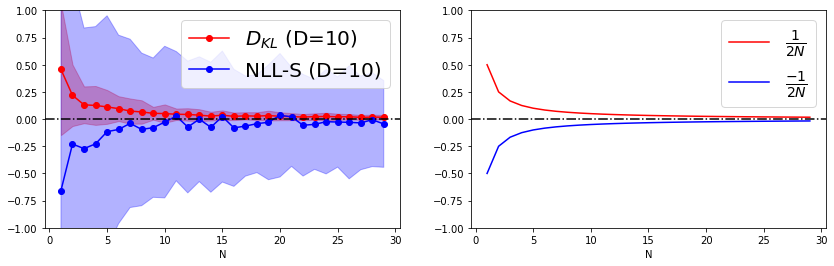

In [9]:
plot_all(D=10, bound=1, estimator=return_q_single); plt.show()

このように、${\bf x}$ の次元 $D$ が何であっても、モデル $q$ のパラメータ数が 1 であれば両方ともに $\frac{1}{2N}, \frac{-1}{2N}$ に収束しています。



---
## レポート問題2(難)

最尤推定が不偏推定ではない場合何が起こるか：

In [205]:
def return_q_m_cov(X):
    ''' サンプルXから最尤推定したガウス分布を返す '''
    mu_ML = np.average(X, axis=0)
    sigmas_ML = np.std(X, axis=0)
    return Gaussian(mu_ML, sigmas_ML)

/Users/akinoritanaka/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/Users/akinoritanaka/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in add
/Users/akinoritanaka/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide


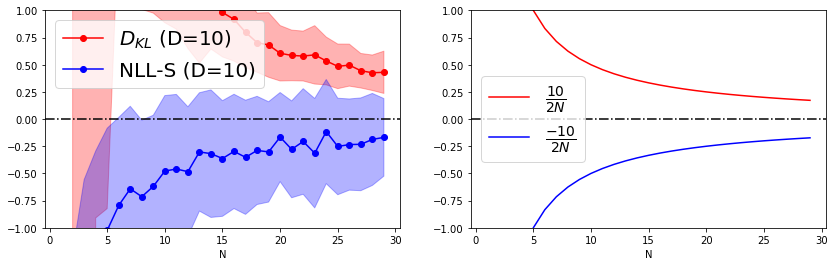

In [243]:
plot_all(D=10, bound=1, estimator=return_q_m_cov); plt.show()

learge $N$ での$D_{KL}$ の振る舞いが $\frac{D}{2N}$ ではなく $\frac{D}{N}$ になっているように見える：

本当に最小化したいもの(<span style="color: red; ">汎化誤差</span>とよばれる)|仕方無く最小化するもの(<span style="color: blue; ">経験誤差</span>とよばれる)
:---:|:---:
$\color{red}{D_{KL}(p\mid\mid q_{\bf m_{ML}^{(N)}, \Sigma_{ML}^{(N)}})} \approx \frac{dim({\bf m})}{N}$|$\color{blue}{- \frac{\log P_N(\bf m_{ML}^{(N)}, \Sigma_{ML}^{(N)})}{N}}-S(p) \approx - \frac{dim({\bf m})}{2N}$

$$
\color{red}{D_{KL}(p\| q_{\bf m_{ML}^{(N)}, \Sigma_{ML}^{(N)}})}\ \lesssim \color{blue}{- \frac{\log P_N(\Theta_{ML}^{(N)})}{N}} + \frac{\frac{3}{2}dim({\bf m})}{N}
$$

真面目に理論解析すると実は $\frac{3}{2}$ ではなく 1 まで厳しくできることがわかる。 $dim({\bf m})$ はモデルの全パラメータ $\Theta = ({\bf m}, \Sigma)$ のうち半分なので、AICの教えに反する。なぜか？->付録？

---